# IMU与车辆

<a href="https://colab.research.google.com/github/LinkHS/Colab/blob/main/IMU/imu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
origin_point = np.array([0, 0, 0])
axes_3d = np.array([[1, 0, 0],
           [0, 1, 0],
           [0, 0, 1]])

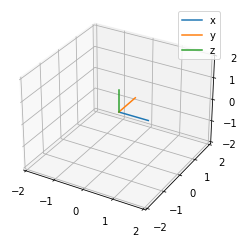

In [3]:
def plot_axes3d(origin_point, axes_3d, ax):
  labels = ['x', 'y', 'z']
  for axis, label in zip(axes_3d, labels):
    x, y, z = np.vstack((origin_point, axis)).T
    ax.plot(x, y, z, label=label)

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)
plot_axes3d(origin_point, axes_3d, ax)
plt.legend()
plt.show()

Consider a counter-clockwise rotation of 90 degrees about the z-axis. 

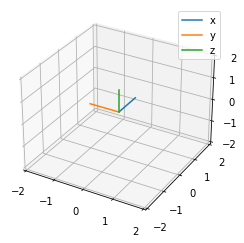

In [4]:
from scipy.spatial.transform import Rotation as R
r = R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)])
r_axes3d = r.apply(axes_3d)

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)

plot_axes3d(origin_point, r_axes3d, ax)
plt.legend()
plt.show()

In [5]:
direction_3dvec = np.array([0, 1, 0])

inv_direction_3dvec = r.inv().apply(direction_3dvec)
inv_direction_3dvec.round()

array([1., 0., 0.])

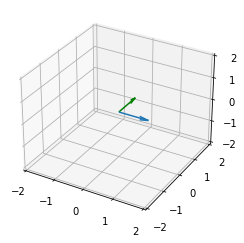

In [6]:
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)

ax.quiver(*origin_point, *direction_3dvec, length=1, color='g')
ax.quiver(*origin_point, *inv_direction_3dvec, length=1)
plt.show()

## 旋转向量
已知两个向量$a,b$，两者之间的位姿变化$Ra=b$，可通过旋转向量求出：

- 旋转角：$\theta = \arccos(\frac{a \cdot b}{|a||b|})$，根据 $a \cdot b = |a| |b| \cos(\theta)$
- 旋转轴：$n = \frac{a \times b}{|a \times b|}$

In [7]:
def align_two_vectors(a, b):
  """ Get a rotation from a to b.
  @a: array_like, shape (3)
  @b: array_like, shape (3)
  """
  theta = np.arccos(a @ b / (np.linalg.norm(a)*np.linalg.norm(b)))
  cross_vector = np.cross(a, b)
  norm = cross_vector / np.linalg.norm(cross_vector)
  #print(np.rad2deg(theta).round(3), norm)

  return theta * norm

rotvec = align_two_vectors(direction_3dvec, inv_direction_3dvec)
r = R.from_rotvec(rotvec)
r.apply(direction_3dvec).round(), inv_direction_3dvec.round()

(array([1., 0., 0.]), array([1., 0., 0.]))

## 车辆与IMU运动关系

### 施密特正交化
根据IMU静止时刻的加速度$b_g$构建Z轴：

In [8]:
w_x = np.array([1, 0, 0])
w_y = np.array([0, 1, 0])
w_z = np.array([0, 0, 1])
b_g = np.array([1.2, 2.4, 1.61])

b_z = b_g / np.linalg.norm(b_g)

np.linalg.norm(b_z)

0.9999999999999999

通过施密特正交化构建X轴：

In [9]:
b_x = w_x - w_x @ b_z * b_z
b_x = b_x / np.linalg.norm(b_x) # normalization

np.linalg.norm(b_x)

0.9999999999999999

通过XZ叉乘构建Y轴

In [10]:
b_y = np.cross(b_x, b_z)
b_y = b_y / np.linalg.norm(b_y) # normalization

np.linalg.norm(b_x)

0.9999999999999999

证明三个轴两两正交：

In [11]:
for v1, v2 in zip((b_x, b_y, b_z), (b_y, b_z, b_x)):
  print((v1 @ v2).round(2))

0.0
0.0
0.0


### IMU坐标系与世界坐标系
静止时，重力在世界坐标系下为$[0, 0, 1]^\mathsf{T}$，在IMU坐标系下为$b_g$，设世界坐标系到IMU坐标系的旋转矩阵为$R_{wb}$，则：

$$
R_{wb}
\begin{bmatrix}
0\\
0\\
1
\end{bmatrix} = b_g
$$

其中$R_{wb}[:,0] = b_x$，$R_{wb}[:,1] = b_y$，$R_{wb}[:,2] = b_z$。对应的，IMU坐标系到世界坐标系的旋转矩阵$R_bw$为：

$$
R_{bw} = R_{wb}^{-1} = R_{wb}^\mathsf{T}
$$

其中$R_{bw}[0,:] = b_x$，$R_{bw}[1,:] = b_y$，$R_{bw}[2,:] = b_z$。

IMU在世界坐标系下的姿态为$R_{bw}$

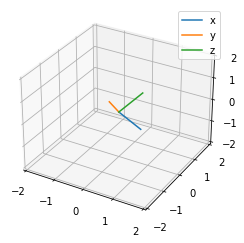

In [12]:
ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim3d(-2, 2)
ax.set_ylim3d(-2, 2)
ax.set_zlim3d(-2, 2)

plot_axes3d(origin_point, np.vstack((b_x, b_y, b_z)), ax)
plt.legend()
plt.show()

### 标定车辆和IMU相对位姿
假设车辆朝正前方行驶，则正前方单位向量为$c_x = [1, 0, 0]$，若测得此时IMU的加速度为$v^b$，那么可以求得$R_{bc} v^b = c_x$。

In [13]:
v_b = np.array([2, 3, 4])
c_w = np.array([1, 0, 0])
R_bc = R.from_rotvec(align_two_vectors(v_b, c_w))

R_bc.apply(v_b / np.linalg.norm(v_b)).round()

array([1., 0., 0.])